Number of times null hypothesis is rejected for rho 0.8: 0 out of 1 simulations
Type 1 Error: 0.0
Bias for Coefficient of Treatment : 0.03136748052688915
MSE for Coefficient of Treatment : 0.00098391883460477
RMSE for Coefficient of Treatment : 0.03136748052688915
Average Standard Error: 0.4690431001690246
Standard Error of the beta_1 distribution: 0.0
The confidence interval is (0.03136748052688915, {0.03136748052688915})


c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Biswajit Palit\AppData\Local\Temp\ipykernel_31784\2163462574.py:111: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(beta1_estimates, bw_adjust=0.5, fill=True)


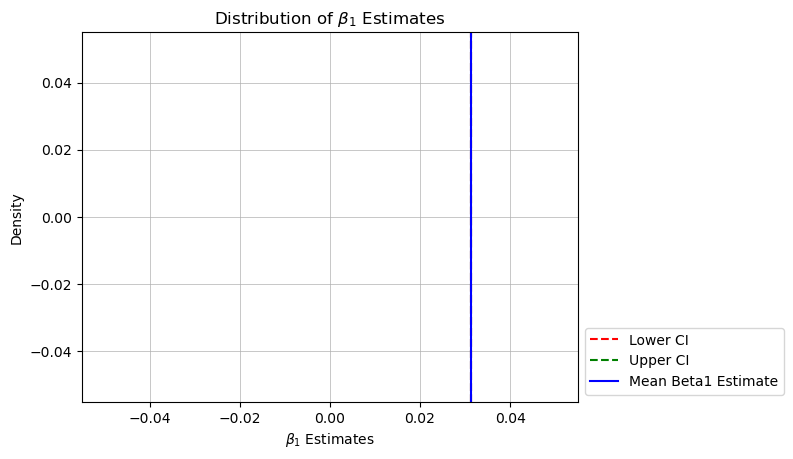

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_gen_homogenous_AR1 import generate_staggered_law_ar1_data

alpha = 0.05  # Significance level
num_simulations = 1
rho = 0.8
num_individuals = 1
N = 50
T = 20


reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []

for _ in range(num_simulations):

    data = generate_staggered_law_ar1_data( N, T, rho, num_individuals) # this time the data generation is inside the loop to ensure everytime new data is generated

    states = data['state'].unique()
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)   # To give the treatment to exactly half the states in a staggered approach

    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)  # Assigning treatment year to each treatment state, staggered between 5 and 15th time period

    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame
    
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

    data['time'] = data['time'].astype(int)
    
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)  # Create state dummy variables

    state_dummies = state_dummies.astype(int)

    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True) # Create time dummy variables

    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)

 
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']]
    
    X = sm.add_constant(X)
    Y = data['value'] 
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['state'].astype(str)})

    bias_value = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias_value)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2
    squared_error_values.append(squared_error)
    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)

    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Checking  if null hypothesis for beta1 is rejected

    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

bias = np.mean(bias_values)
mse = np.mean(squared_error)   
rmse = np.sqrt(mse)  
average_standard_error = np.mean(standard_error_values)   
std_error_beta_distribution = np.std(beta1_estimates)

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected for rho {rho}: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.kdeplot(beta1_estimates, bw_adjust=0.5, fill=True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()





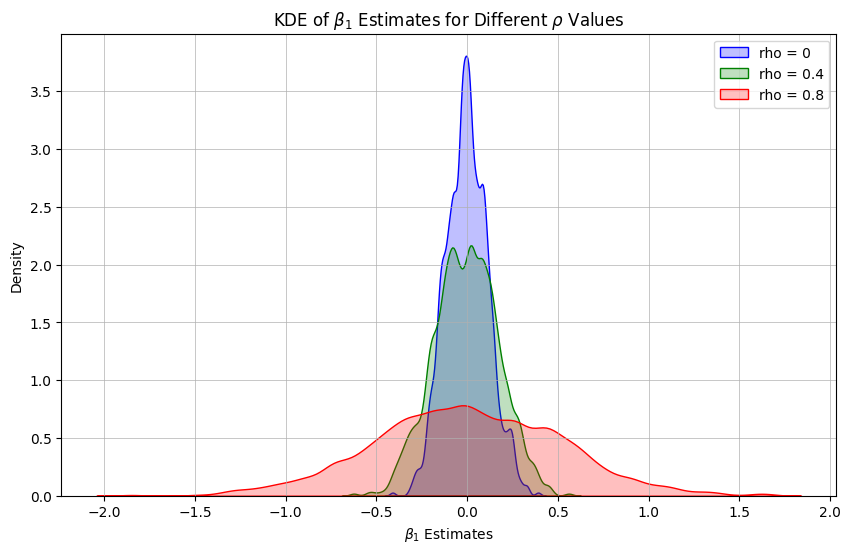

In [2]:
# to vislualize the KDEs for rhos 0, 0.4 and 0.8 in one plot

alpha = 0.05  
num_simulations = 1000
rhos = [0, 0.4, 0.8]  # Different values of rho to simulate
num_individuals = 1
N = 50
T = 20

# Initializing a dictionary to hold beta1 estimates for different rhos

beta1_estimates_dict = {rho: [] for rho in rhos}

for rho in rhos:
    print(f"Running simulations for rho = {rho}")
    for _ in range(num_simulations):
        data = generate_staggered_law_ar1_data(N, T, rho, num_individuals)

        states = data['state'].unique()
        
        treatment_states = np.random.choice(states, size=len(states)//2, replace=False)   # To give the treatment to exactly half the states in a staggered approach

        treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)  # Assigning treatment year to each treatment state, staggered between 5 and 15th time period

        state_to_treatment_year = dict(zip(treatment_states, treatment_years))

        # Adding a treatment column to the DataFrame
        
        data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

        data['time'] = data['time'].astype(int)
    
        state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)  # Create state dummy variables

        state_dummies = state_dummies.astype(int)

        time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True) # Create time dummy variables

        time_dummies = time_dummies.astype(int)

        data = pd.concat([data, state_dummies, time_dummies], axis=1)

        columns_to_exclude = ['state', 'value', 'individual', 'time']

        X_columns = [col for col in data.columns if col not in columns_to_exclude]

        X = data[X_columns]
        X = sm.add_constant(X)
        Y = data['value']
        model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['state'].astype(str)})

        
        beta1_estimates_dict[rho].append(model.params['TREATMENT'])

# Plotting
        
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']  # Colors for different rhos
for idx, rho in enumerate(rhos):
    sns.kdeplot(beta1_estimates_dict[rho], bw_adjust=0.5, fill=True, label=f'rho = {rho}', color=colors[idx])

plt.xlabel(r'$\beta_1$ Estimates')
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates for Different $\rho$ Values')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()


In [2]:
data 

,state,individual,time,value,TREATMENT,state_2,state_3,state_4,state_5,state_6,...,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19
0,1,1,0,-2.139478,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,-0.848112,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,-3.861733,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0.279682,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,-3.068720,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,46,1,19,0.533347,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,47,1,19,-1.463617,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,48,1,19,-4.759370,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,49,1,19,0.331224,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
